## Curve Fit for Ceva Experiment
### Made with ❤️ in ECS Lab by Francesco Barchi, Emanuele Parisi, Amirhossein Moallemi

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, curve_fit

import time
import scipy.fft
import scipy.signal

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_slice_t(t, s, r):
    mask = np.logical_and(t>r[0], t<r[1]) 
    return t[mask], s[mask]-np.mean(s)

def passband_filter(signal, fs, fs_min=0.5, fs_max=30.0, order=10):
    sos = scipy.signal.butter(order, (fs_min/(fs/2+1), fs_max/(fs/2+1)), btype='bandpass', output='sos')
    # sos = scipy.signal.bessel(order, (fs_min/(fs/2+1), fs_max/(fs/2+1)), btype='bandpass', output='sos')
    signal -= np.mean(signal)
    signal = scipy.signal.sosfilt(sos, signal)
    return signal

def get_fft(t, s):
    e = np.abs(np.fft.fft(s-np.mean(s)))*2/len(s)
    f = np.abs(np.fft.fftfreq(len(s), ((t[1]-t[0]))))
    return f, e

def add_noise(s, a, b):
    noise = (b - a) * np.random.random_sample(s.shape) + a
    return s + noise

def get_model(popt):
    # https://en.wikipedia.org/wiki/Damping
    f_nat = popt[1]/(2*np.pi)
    dump = popt[3]/np.sqrt(popt[3]**2+popt[1]**2)
    return f_nat, dump

def mean_fb(s, p=0.1):
    """If the signal is a dumping event, remove the mean from the end of signal!"""
    l = len(s)
    ths = int(-l*p)
    print(l, ths)
    return s-np.mean(s)

In [3]:
def fit_func(x, c0, c1, c2, c3):
    return c0 * np.exp(-c3*x) * np.sin(c1*x+c2)

### Example

[1, 50, 0, 0.4] [ 1.         50.         -6.28318531  0.4       ]


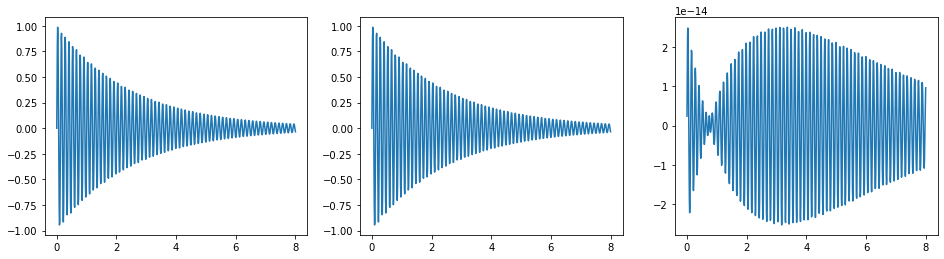

In [4]:
t = 8
fs = 100
samples = fs*t
x = np.linspace(0, t, samples)

params = [1, 50, 0, 0.4]
s = fit_func(x, *params)

params2, _ = curve_fit(fit_func, x, s)
s2 = fit_func(x, *params2)
print(params, params2)

fig, axs = plt.subplots(1,3, figsize=(16,4))
axs[0].plot(x, s)
axs[1].plot(x, s2)
axs[2].plot(x, s-s2)

### Test on Ceva Experiment

In [5]:
data = np.load("Vertical_axis.npy", allow_pickle=True).item()
data.keys()

dict_keys(['pcb_s1_w0', 'pcb_s2_w0', 'ism_hp_s1_w0', 'ism_hp_s2_w0', 'ism_lp_s1_w0', 'ism_lp_s2_w0', 'lis_s1_w0', 'lis_s2_w0'])

In [6]:
data['pcb_s1_w0'].shape

(5000, 94)

Best signal ID: 74
Model parameters: [-3.60294674e-03  3.47247779e+01 -2.91601351e+00  2.78031778e-01]


(0.0, 25.0)

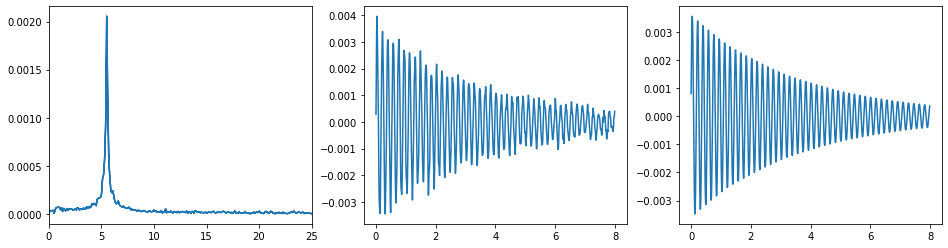

In [7]:
# sensors = ['pcb_s1_w0', 'pcb_s2_w0', 'ism_hp_s1_w0', 'ism_hp_s2_w0', 'ism_lp_s1_w0', 'ism_lp_s2_w0', 'lis_s1_w0', 'lis_s2_w0']
# sensors_fs = [500, 500, 833, 833, 52, 52, 100, 100]

# w0_sensors = ['pcb_s1_w0', 'ism_hp_s1_w0', 'ism_lp_s1_w0', 'lis_s1_w0']
# w0_sensors_fs = [500, 833, 52, 100]

# Given a sensor, get the most "clear" signal
sensor = 'lis_s1_w0'
sensor_fs = 100

# Get list of signals
signals = list()
for _w in range(data[sensor].shape[1]):
    signals.append(data[sensor][:, _w])

# Compute the signal fft (abs)
signals_fft = list()
for _s in signals:
    _t = np.arange(0, len(_s))/sensor_fs
    signals_fft.append(get_fft(_t, _s))

# Get the signal with the highest fft (abs) coefficent
_argmax = np.argmax([np.max(_fft_abs) for _fft_f, _fft_abs in signals_fft])
print(f"Best signal ID: {_argmax}")

# Get the fft of the chosed signal
s_fft_f, s_fft_abs = signals_fft[_argmax]

# Remove first signal samples
s = signals[_argmax][200:]
# Time axis
t = np.arange(0, len(s))/sensor_fs

# Fit
popt, pcov = curve_fit(fit_func, t, s)
s1 = fit_func(t, *popt)
print(f"Model parameters: {popt}")

# Plot
fig, axs = plt.subplots(1,3, figsize=(16,4))
axs[0].plot(s_fft_f, s_fft_abs)
axs[1].plot(t, s)
axs[2].plot(t, s1)
axs[0].set_xlim(0,25)

#### Work! ... The trick is to provide a good time axis!

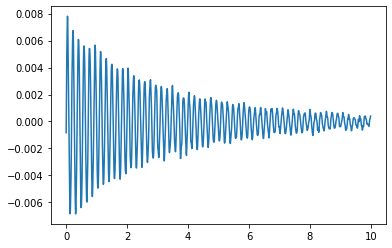

In [8]:
# Test again on whole signal 74
signal_id = 74
signal = data['lis_s1_w0'][:, signal_id]
signal_t = np.arange(0, len(signal))/100
plt.plot(signal_t, signal)

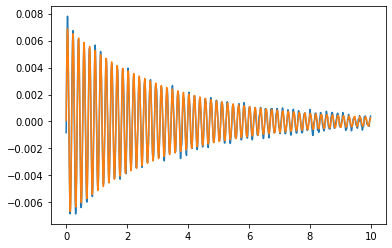

In [9]:
popt, pcov = curve_fit(fit_func, signal_t, signal)
signal_fitted = fit_func(signal_t, *popt)
plt.plot(signal_t, signal)
plt.plot(signal_t, signal_fitted)

[[ 1.85383918e-09 -1.49641694e-09  4.62506550e-09 -8.43236718e-08]
 [-1.49641694e-09  7.39594375e-06 -1.18047019e-05  6.96167581e-08]
 [ 4.62506550e-09 -1.18047019e-05  3.68431321e-05 -2.12400507e-07]
 [-8.43236718e-08  6.96167581e-08 -2.12400507e-07  7.45134683e-06]]


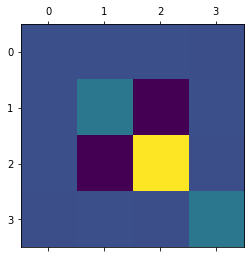

In [10]:
print(pcov)
_ = plt.matshow(pcov)

In [11]:
model_f, model_dump = get_model(popt)
print(f"Freq. {model_f:.3e}\nDump. {model_dump:.3e}")

Freq. 5.521e+00
Dump. 8.859e-03


#### Test on Amir's event (golden_model) - Same signal on all sensors

In [12]:
data = np.load('golden_model.npy', allow_pickle=True).item()

# Amir's values
# pcb_start = 69
# lis_start = 31
# hp_start = 135
# lp_start = 13

# New values
pcb_start = 500//2
lis_start = 100//2
hp_start = 833//2
lp_start = 52//3

print(pcb_start, lis_start, hp_start, lp_start)

period = 15
lis_conv = 2/(2**15)
pcb = mean_fb(data['pcb'][pcb_start: pcb_start + (500*period)])
lis = mean_fb(data['lis'][lis_start: lis_start + (100*period)] * lis_conv)
hp = mean_fb(data['hp'][hp_start: hp_start + (833*period)])
lp = mean_fb(data['lp'][lp_start: lp_start + (52*period)])

250 50 416 17
7500 -750
1500 -150
12495 -1249
780 -78


Freq. 5.497e+00
Dump. 8.300e-03


Text(0.5, 1.0, 'PCB (5.497143049365043, 0.008300156951216695)')

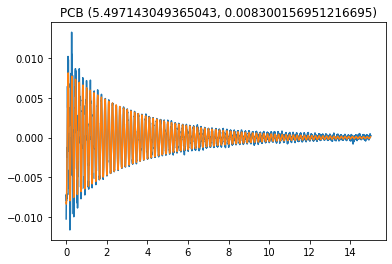

In [13]:
signal = pcb
signal_t = np.arange(0, len(signal))/500

popt, pcov = curve_fit(fit_func, signal_t, signal)
signal_fitted = fit_func(signal_t, *popt)

#print(get_model(popt))
model_f, model_dump = get_model(popt)
print(f"Freq. {model_f:.3e}\nDump. {model_dump:.3e}")

plt.plot(signal_t, signal)
plt.plot(signal_t, signal_fitted)
plt.title(f"PCB {get_model(popt)}")

Freq. 5.539e+00
Dump. 8.608e-03


Text(0.5, 1.0, 'LIS (5.538508217116881, 0.008607580733464624)')

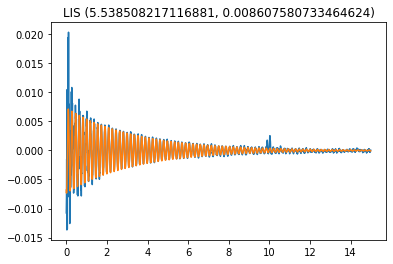

In [14]:
signal = lis
signal_t = np.arange(0, len(signal))/100

popt, pcov = curve_fit(fit_func, signal_t, signal)
signal_fitted = fit_func(signal_t, *popt)

#print(get_model(popt))
model_f, model_dump = get_model(popt)
print(f"Freq. {model_f:.3e}\nDump. {model_dump:.3e}")

plt.plot(signal_t, signal)
plt.plot(signal_t, signal_fitted)
plt.title(f"LIS {get_model(popt)}")

Freq. 5.591e+00
Dump. 8.275e-03


Text(0.5, 1.0, 'HP (5.5905790720029165, 0.008274850226375093)')

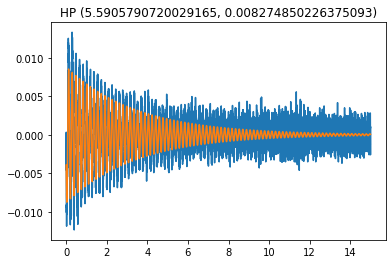

In [15]:
signal = hp
signal_t = np.arange(0, len(signal))/833

popt, pcov = curve_fit(fit_func, signal_t, signal)
signal_fitted = fit_func(signal_t, *popt)

#print(get_model(popt))
model_f, model_dump = get_model(popt)
print(f"Freq. {model_f:.3e}\nDump. {model_dump:.3e}")

plt.plot(signal_t, signal)
plt.plot(signal_t, signal_fitted)
plt.title(f"HP {get_model(popt)}")

Freq. 5.567e+00
Dump. 1.158e-02


Text(0.5, 1.0, 'LP (5.56678788064309, 0.011575824622421824)')

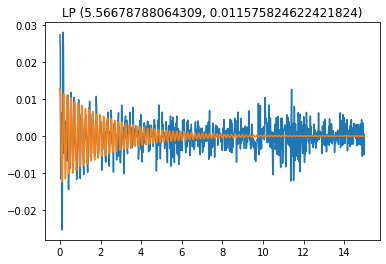

In [16]:
signal = lp
signal_t = np.arange(0, len(signal))/52

popt, pcov = curve_fit(fit_func, signal_t, signal)
signal_fitted = fit_func(signal_t, *popt)

#print(get_model(popt))
model_f, model_dump = get_model(popt)
print(f"Freq. {model_f:.3e}\nDump. {model_dump:.3e}")

plt.plot(signal_t, signal)
plt.plot(signal_t, signal_fitted)
plt.title(f"LP {get_model(popt)}")